In [1]:
# Basic imports
%matplotlib inline
import openpathsampling as paths
import numpy as np

# used for visualization of the 2D toy system
from toy_plot_helpers import ToyPlot

In [2]:
import onion

In [3]:
import pyemma.msm
import pyemma.plots as mplt
import pyemma.coordinates as cc

In [4]:
import matplotlib.pyplot as plt

In [5]:
import msmtools as mt

In [6]:
%config InlineBackend.figure_format='retina'

### Basic system setup

First we set up our system: for the toy dynamics, this involves defining a potential energy surface (PES), setting up an integrator, and giving the simulation an initial configuration. In real MD systems, the PES is handled by the combination of a topology file and a force field definition, and the initial configuration would come from a file instead of being described by hand.

In [7]:
# convenience for the toy dynamics
import openpathsampling.engines.toy as toys

### Set up the toy system

First we need to describe the system we'll be simulating. With biomolecular systems, this is often done with an initial PDB structure and a choice of force field. For the toy model, we need to give a snapshot as a template, as well as a potential energy surface. The template snapshot also includes a pointer to the topology information (which is relatively simple for the toy systems.)

In [8]:
# Toy_PES supports adding/subtracting various PESs. 
# The OuterWalls PES type gives an x^6+y^6 boundary to the system.
pes = (
    toys.OuterWalls([1.0, 1.0], [0.0, 0.0]) +
    toys.Gaussian(-0.7, [12.0, 12.0], [0.0, 0.4]) +
    toys.Gaussian(-0.7, [12.0, 12.0], [-0.5, -0.5]) +
    toys.Gaussian(-0.7, [12.0, 12.0], [0.5, -0.5])
)

topology=toys.Topology(
    n_spatial = 2,
    masses =[1.0, 1.0],
    pes = pes
)

template = toys.Snapshot(
    coordinates=np.array([[-0.5, -0.5]]), 
    velocities=np.array([[0.0,0.0]]),
    topology=topology
)

### Set up the engine

The engine needs the template snapshot we set up above, as well as an integrator and a few other options.

In [9]:
integ = toys.LangevinBAOABIntegrator(dt=0.02, temperature=0.1, gamma=2.5)

options={
    'integ' : integ,
    'n_frames_max' : 5000,
    'nsteps_per_frame' : 10
}

toy_eng = toys.Engine(
    options=options,
    template=template
)
toy_eng.initialized = True

toy_eng.current_snapshot = template

Finally, we make this engine into the default engine for any `PathMover` that requires an one (e.g., shooting movers, minus movers).

In [10]:
paths.PathMover.engine = toy_eng

Now let's look at the potential energy surface we've created:

In [11]:
plot = ToyPlot()
plot.contour_range = np.arange(-1.5, 1.0, 0.1)
plot.add_pes(pes)

In [12]:
engine = toy_eng

In [13]:
first = toys.Snapshot(
    coordinates=np.array([[-0.5, -0.5]]), 
    velocities=np.array([[1.0,0.0]]),
)

In [22]:
engine.current_snapshot = first
initial_traj = engine.generate_n_frames(80000)

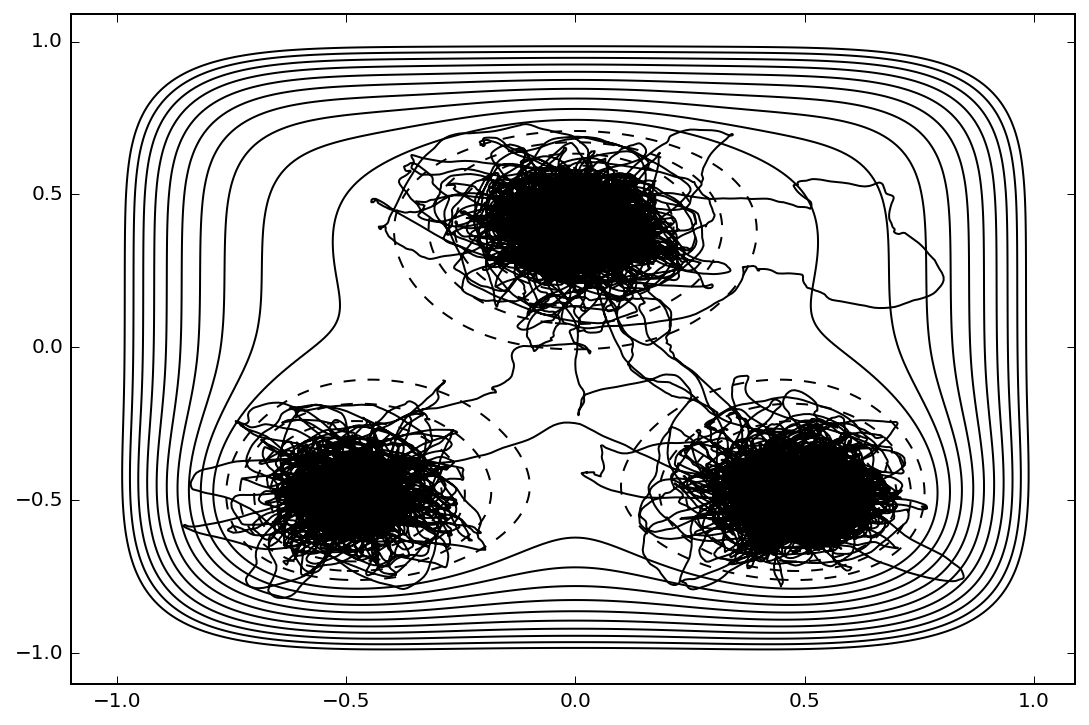

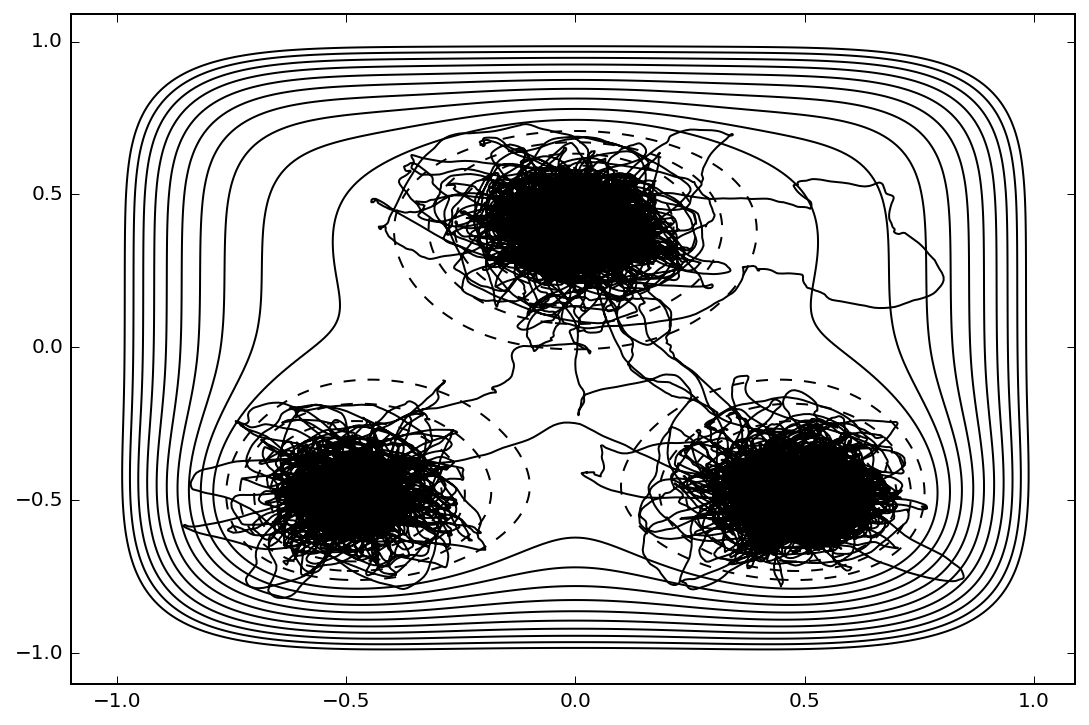

In [23]:
plot.plot([initial_traj])

In [24]:
data = initial_traj.coordinates.reshape((-1,2))

In [25]:
kmeans = cc.cluster_kmeans(data)

11-03-16 09:25:35 pyemma.coordinates.clustering.kmeans.KmeansClustering[0] INFO     The number of cluster centers was not specified, using min(sqrt(N), 5000)=282 as n_clusters.
11-03-16 09:25:38 pyemma.coordinates.clustering.kmeans.KmeansClustering[0] INFO     Cluster centers converged after 4 steps.


In [26]:
dtraj = kmeans.assign(data)

In [27]:
#lags = [1,2,5,10,20,50,100,200,500,1000]
#its = msm.its(dtraj, lags=lags)

In [28]:
#mplt.plot_implied_timescales(its)

Just one state, so let's find the center and decompose it ito interfaces

In [29]:
DTS = pyemma.msm.estimators._dtraj_stats.DiscreteTrajectoryStats

In [30]:
dts = DTS(dtraj)

In [31]:
dts.count_lagged(1)

In [32]:
full_count_matrix = dts.count_matrix()

In [33]:
P_mat = np.array(mt.estimation.tmatrix(full_count_matrix).toarray())

In [34]:
pymsm = pyemma.msm.estimate_markov_model(dtraj, 1)
conn_sets = pymsm.connected_sets

large_mfpt = np.zeros(P_mat.shape)
all_centers = []
for conn_set in conn_sets:
    cset = np.array(conn_set)
    mat = P_mat[cset.reshape(-1,1),cset]
    mat = np.dot(np.diag(1.0 / np.sum(mat, axis=1)), mat)
    
    if len(mat) > 1:
        msm = onion.MSM(mat)
        mfpt_m = msm.mfpt_matrix()
        large_mfpt[cset.reshape(-1,1), cset] = mfpt_m
        center_state = np.argmin(np.max(mfpt_m, axis=1))
        all_centers.append(cset[center_state])

In [35]:
all_centers

[205]

In [36]:
all_states = np.concatenate(conn_sets)

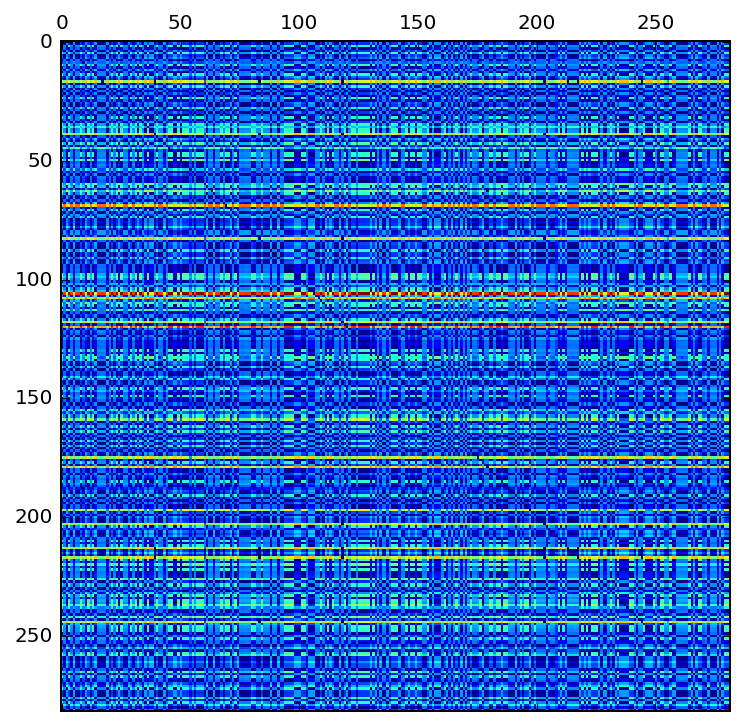

In [37]:
plt.matshow(large_mfpt[all_states.reshape(-1,1),all_states])

(-1, 1)

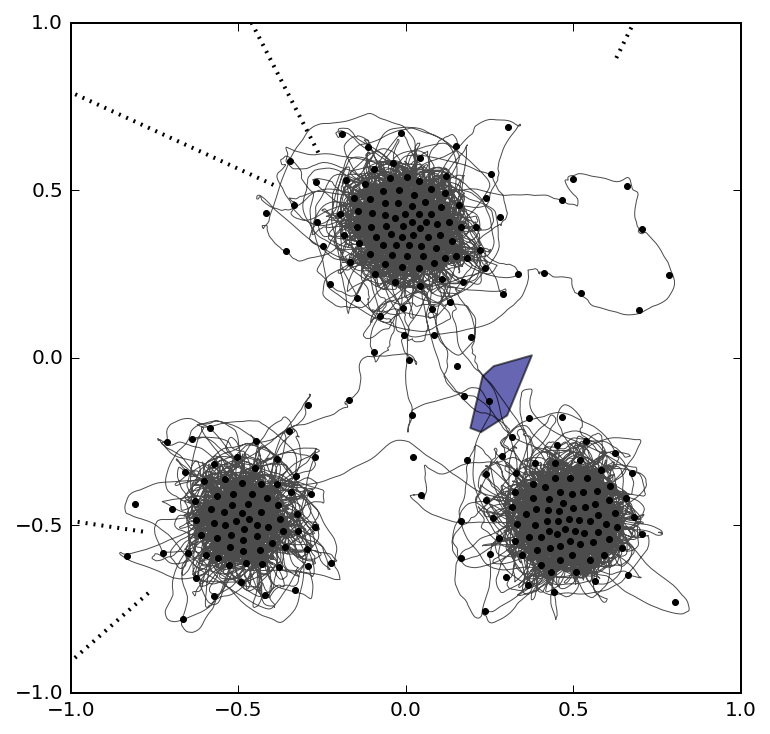

In [38]:
#ccc = kmeans.clustercenters[pymsm.active_set]
st = 20
ccc = kmeans.clustercenters
total_mfpt = large_mfpt[all_centers].sum(axis=0)
values = total_mfpt
onion.voronoi_plot_2D(ccc, values, traj=data, max_mfpt=5000, radius=2, color_unlimited=True, show_centers=True)
plt.xlim(-1,1)
plt.ylim(-1,1)

In [92]:
print forws.shape
print backs.shape
print close_backs.shape

(104,)
(104,)
(62,)


(-1, 1)

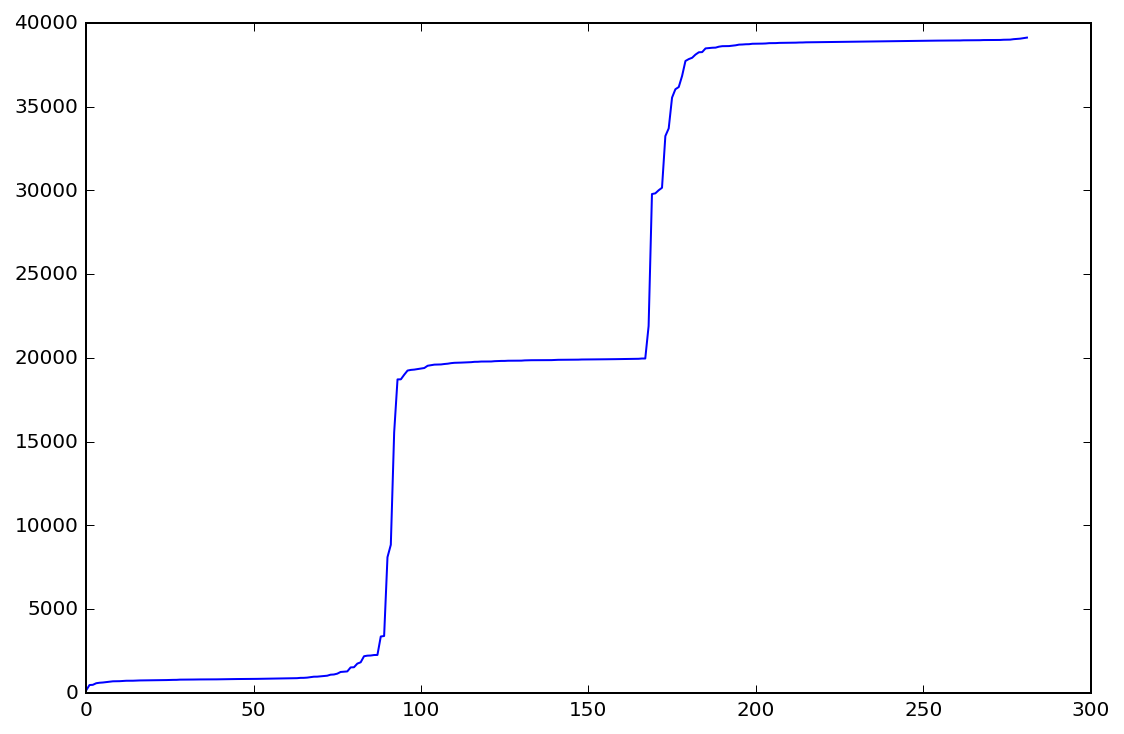

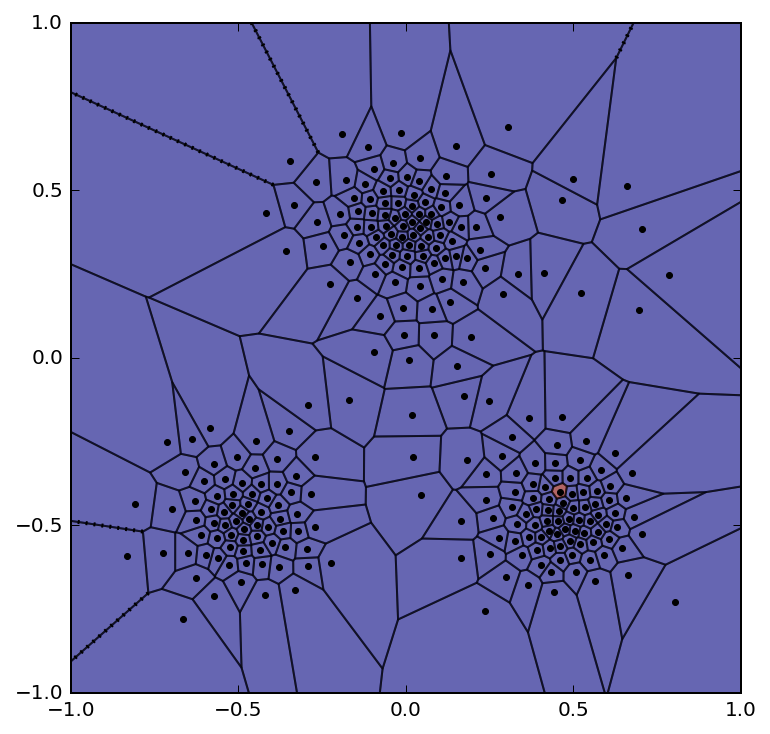

In [153]:
all_cs = []
for tau in range(5000):
    states = []
    for n in range(len(large_mfpt)):
        row = large_mfpt.T[n]
        inds = np.argwhere(row < tau)
        inds = inds[inds != n]
        if len(inds > 0):
            forws = large_mfpt.T[n, inds].reshape(-1)
            backs = large_mfpt[n, inds].reshape(-1)
            close_backs = np.where(backs < forws)[0]
        #    print np.array([row, backs]).T
        #     print n, len(inds), len(close_backs)
            if len(inds) == len(close_backs) and len(inds) > 20:
    #             print len(inds), len(close_backs), n
                states.append(n)

    all_cs.append(states)

for s in states:
    plt.plot(sorted(large_mfpt[s]))
    
ccc = kmeans.clustercenters
v = large_mfpt[st]
v = np.zeros(len(large_mfpt))
v[states] = 1.0
onion.voronoi_plot_2D(ccc, v, max_mfpt=5000, radius=2, color_unlimited=True, show_centers=True)
plt.xlim(-1,1)
plt.ylim(-1,1)

(-1, 1)

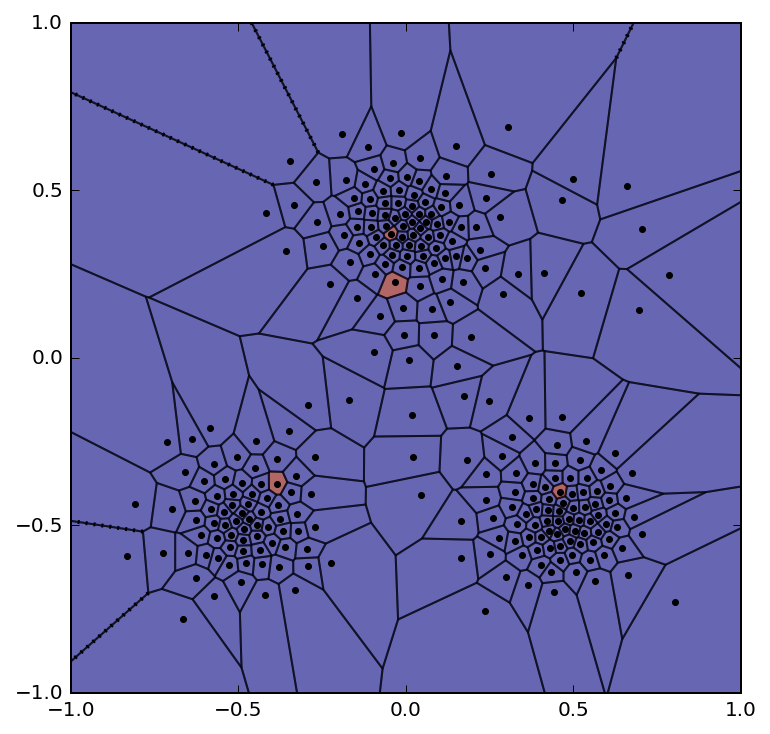

In [154]:
tot = np.concatenate(all_cs)
unique_centers = np.unique(tot).astype(np.int).tolist()
ccc = kmeans.clustercenters
v = large_mfpt[st]
v = np.zeros(len(large_mfpt))
v[unique_centers] = 1.0
onion.voronoi_plot_2D(ccc, v, max_mfpt=5000, radius=2, color_unlimited=True, show_centers=True)
plt.xlim(-1,1)
plt.ylim(-1,1)

(-1, 1)

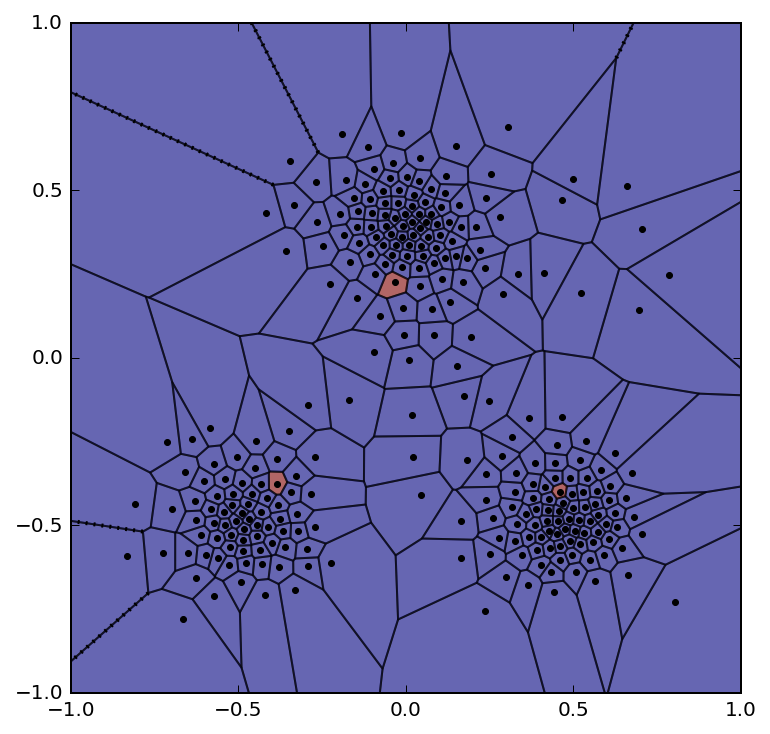

In [132]:
ccc = kmeans.clustercenters
v = large_mfpt[st]
v = np.zeros(len(large_mfpt))
v[states] = 1.0
onion.voronoi_plot_2D(ccc, v, max_mfpt=5000, radius=2, color_unlimited=True, show_centers=True)
plt.xlim(-1,1)
plt.ylim(-1,1)

In [47]:
tot_mfpt=np.array([large_mfpt, large_mfpt.T]).T

In [48]:
np.argwhere(large_mfpt < 5000)

array([[  0,   0],
       [  0,   3],
       [  0,   8],
       ..., 
       [281, 275],
       [281, 277],
       [281, 281]])

In [83]:
#msm = onion.MSM(pymsm.P)

In [131]:
eq = msm.stationary_distribution

In [86]:
mfpt = msm.mfpt_matrix()

In [132]:
center_state = np.argmin(np.max(mfpt, axis=1))
print center_state

26


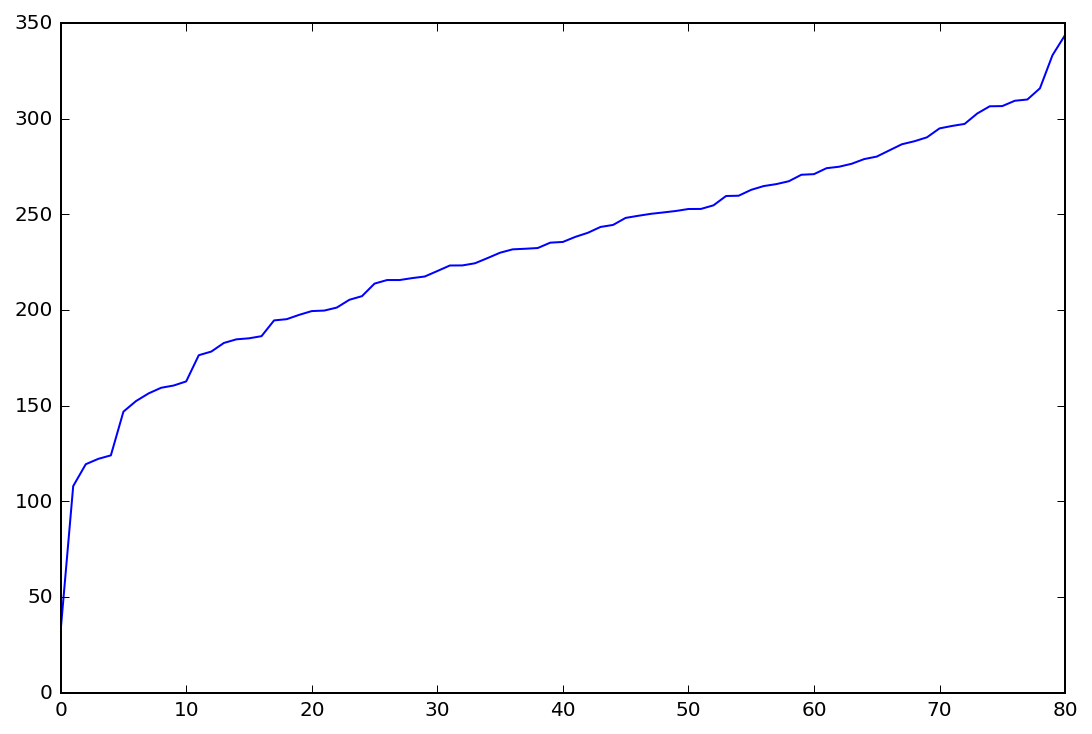

In [133]:
plt.plot(sorted(mfpt[center_state]))

In [134]:
print msm.stationary_distribution

[ 0.02096168  0.03130676  0.01618688  0.01608591  0.03040273  0.00879784
  0.01537315  0.01925548  0.01390107  0.01996356  0.00451993  0.01829609
  0.02839943  0.00559735  0.02503469  0.0134689   0.00844649  0.01633133
  0.02882161  0.00445946  0.02599389  0.02389835  0.02864472  0.01800236
  0.0153991   0.0033499   0.01583561  0.01268346  0.00475982  0.01240939
  0.00284628  0.02145636  0.01629786  0.0252494   0.01752804  0.00545968
  0.0259138   0.03984081  0.02351097  0.02748607  0.00839652  0.01345966
  0.04050277  0.01619857  0.0140118   0.01448815  0.03167805  0.02324448
  0.01243709  0.02342814  0.00283801  0.02259199  0.03702424  0.01256213
  0.0055019   0.00195864  0.00750162]


In [76]:
np.argmin(((ccc - np.array([-0.0, +0.35]))**2).sum(axis=1))

134

(-1, 1)

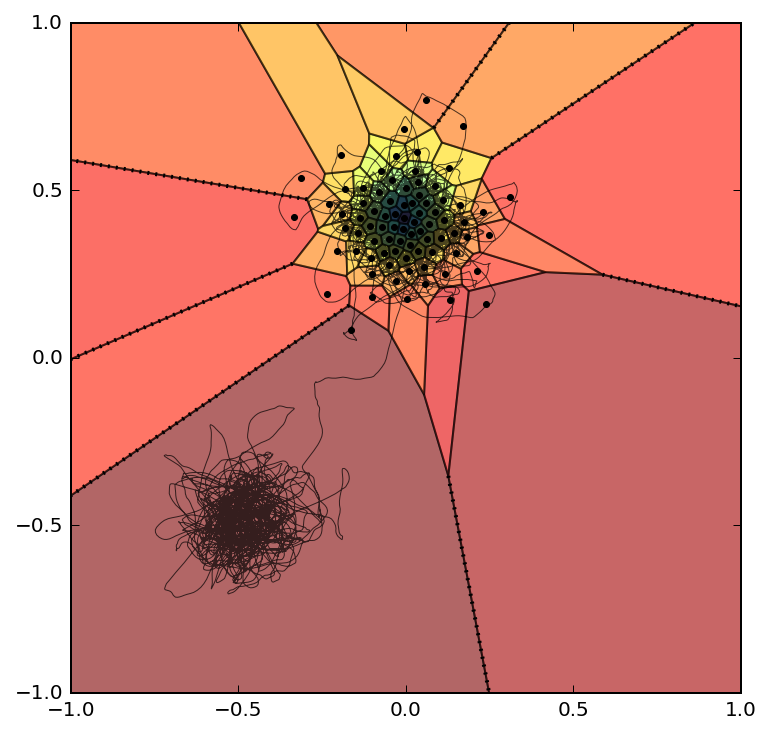

In [91]:
ccc = kmeans.clustercenters[pymsm.active_set]
st = center_state
#ccc = kmeans.clustercenters
onion.voronoi_plot_2D(ccc, mfpt[st], traj=data, max_mfpt=5000, radius=2, color_unlimited=True, show_centers=True)
plt.xlim(-1,1)
plt.ylim(-1,1)

In [81]:
row = 200
sind = np.argsort(m1[row])
#sind = range(len(m1))
plt.plot(m1[row,sind])

NameError: name 'm1' is not defined

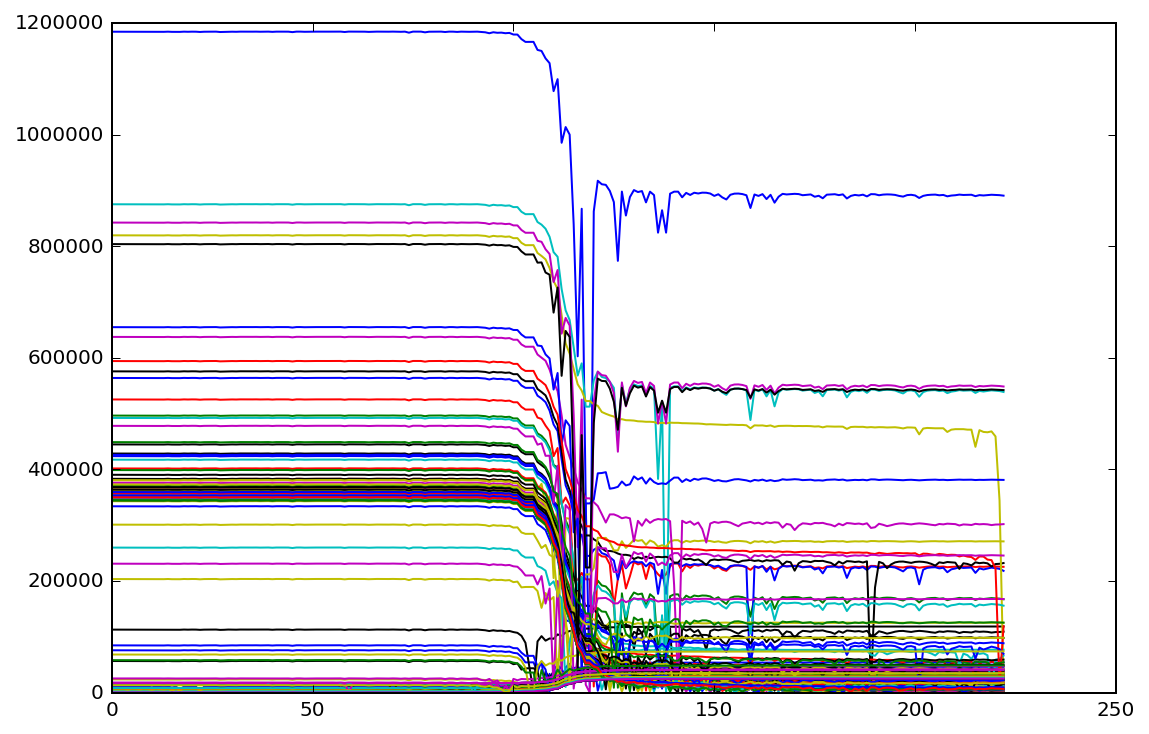

In [457]:
sind = np.argsort(m1[10])
#sind = range(len(m1))
for n in range(len(m1)):
    plt.plot(m1[n,sind])

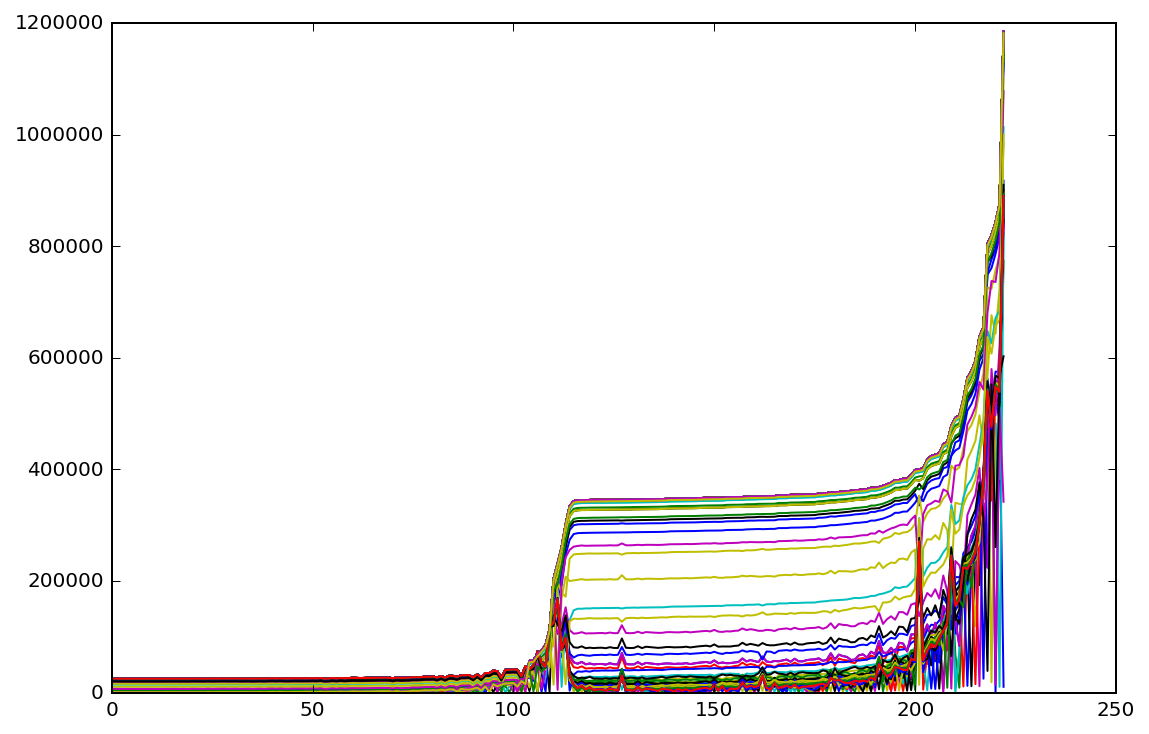

In [485]:
sind = np.argsort(m1[:,10])
#sind = range(len(m1))
for n in range(len(m1)):
    plt.plot(m1[sind,n])

In [504]:
u = np.linalg.eig(mymsm.P)[1]

In [505]:
u = np.linalg.eig(m1)[1]
np.linalg.inv(np.dot(u, u.T))

array([[ 1.01180175+0.j,  0.02325979+0.j,  0.00702857+0.j, ...,
         0.01205473+0.j,  0.02209112+0.j,  0.05935311+0.j],
       [ 0.02325979+0.j,  1.21321194+0.j,  0.02373106+0.j, ...,
         0.20608656+0.j,  0.21223632+0.j,  0.43477743+0.j],
       [ 0.00702857+0.j,  0.02373106+0.j,  1.00566355+0.j, ...,
         0.02855827+0.j,  0.02298842+0.j,  0.01418391+0.j],
       ..., 
       [ 0.01205473+0.j,  0.20608656+0.j,  0.02855827+0.j, ...,
         1.23989491+0.j,  0.20471566+0.j,  0.45370398+0.j],
       [ 0.02209112+0.j,  0.21223632+0.j,  0.02298842+0.j, ...,
         0.20471566+0.j,  1.21162170+0.j,  0.43819350+0.j],
       [ 0.05935311+0.j,  0.43477743+0.j,  0.01418391+0.j, ...,
         0.45370398+0.j,  0.43819350+0.j, -0.53915358-0.j]])

In [395]:
xrange(10)[:5]

TypeError: sequence index must be integer, not 'slice'

vor = Voronoi(ccc)

In [466]:
np.linalg.svd(np.dot(m1.T, np.linalg.inv(m1)) - np.identity(len(m1)))[1]

array([  2.47681361e+02,   4.14931030e+00,   3.01658450e-10,
         5.70690369e-11,   5.20764394e-11,   4.03886909e-11,
         3.32483211e-11,   2.62516685e-11,   2.16000250e-11,
         2.09721599e-11,   1.83624280e-11,   1.67442302e-11,
         1.56268144e-11,   1.45872008e-11,   1.41937967e-11,
         1.24299826e-11,   1.17312364e-11,   1.16230644e-11,
         1.09835558e-11,   1.03416565e-11,   9.70279473e-12,
         9.50315883e-12,   9.31839958e-12,   9.00782400e-12,
         8.53732680e-12,   8.27302706e-12,   8.07880373e-12,
         8.03209307e-12,   7.48603019e-12,   7.13191443e-12,
         6.95540631e-12,   6.70933003e-12,   6.35925270e-12,
         6.07638181e-12,   5.85972444e-12,   5.60282044e-12,
         5.40054303e-12,   5.28925013e-12,   5.10675476e-12,
         4.63376976e-12,   4.43476162e-12,   4.26476799e-12,
         4.21807650e-12,   4.17189603e-12,   4.12622342e-12,
         3.81541541e-12,   3.80152956e-12,   3.56496178e-12,
         3.30813644e-12,

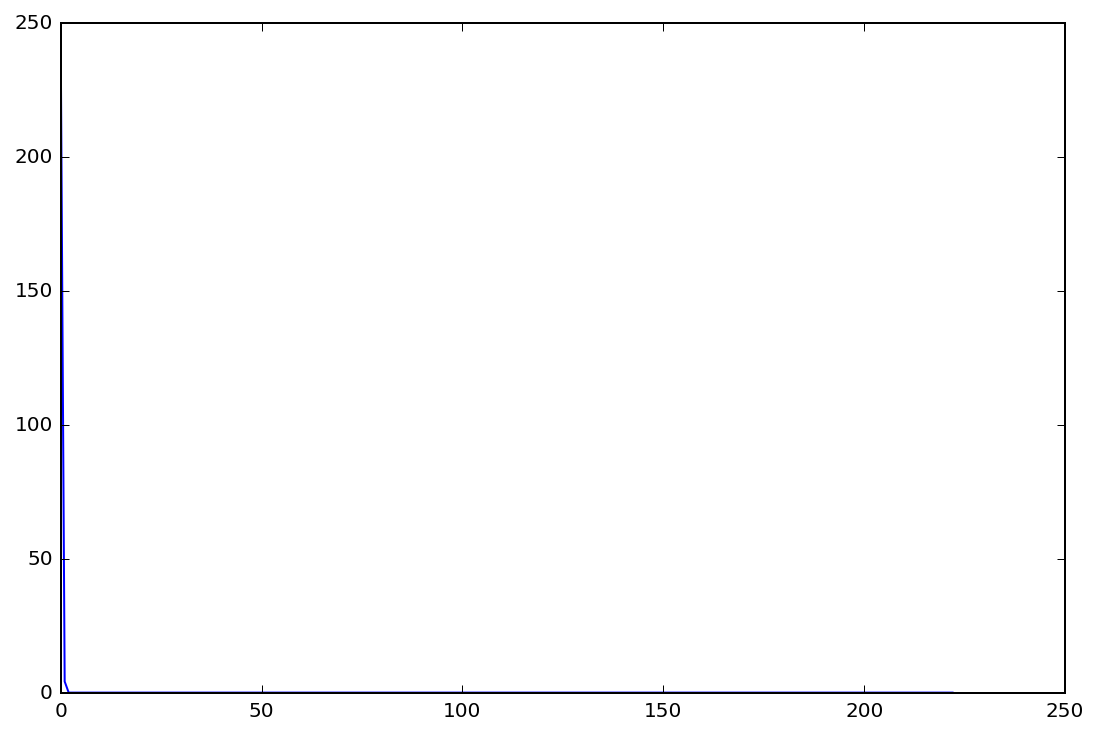

In [465]:
plt.plot(np.linalg.svd(np.dot(m1.T, np.linalg.inv(m1)) - np.identity(len(m1)))[1])

In [109]:
mymsm.timescales()[0]

391.73575376854535

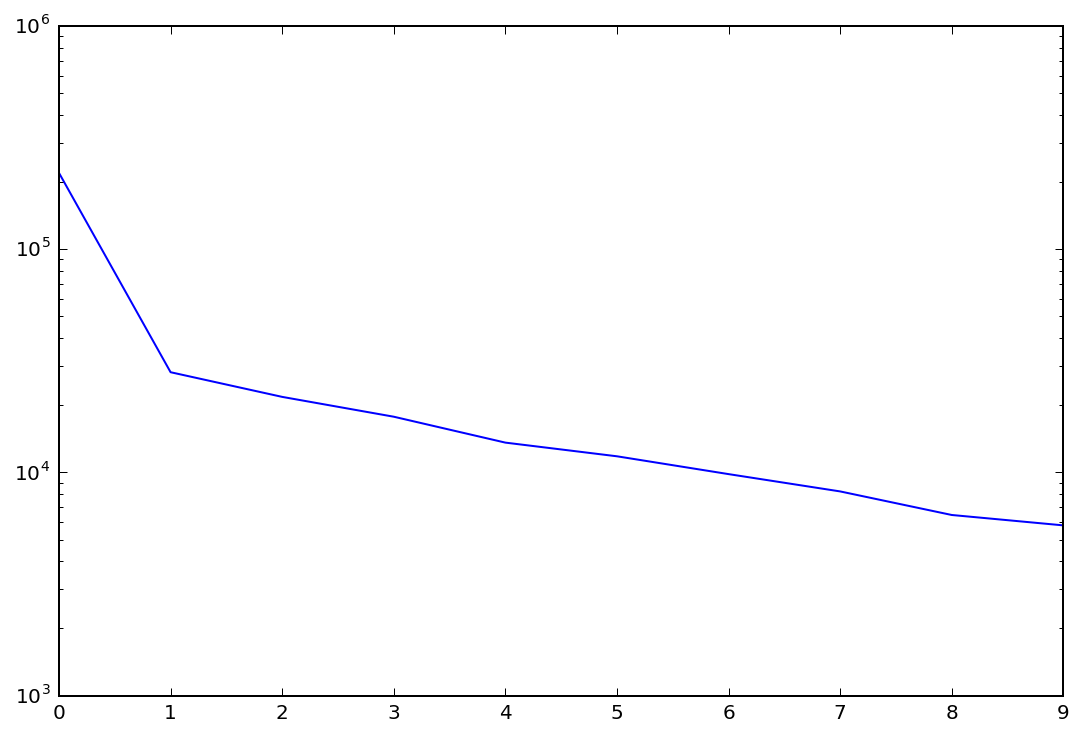

In [34]:
plt.plot(np.abs(np.linalg.eigvals(m1))[0:10])
ax = plt.axes()
ax.set_yscale('log')

In [35]:
mmv, mmd, mmw = np.linalg.svd(m1)

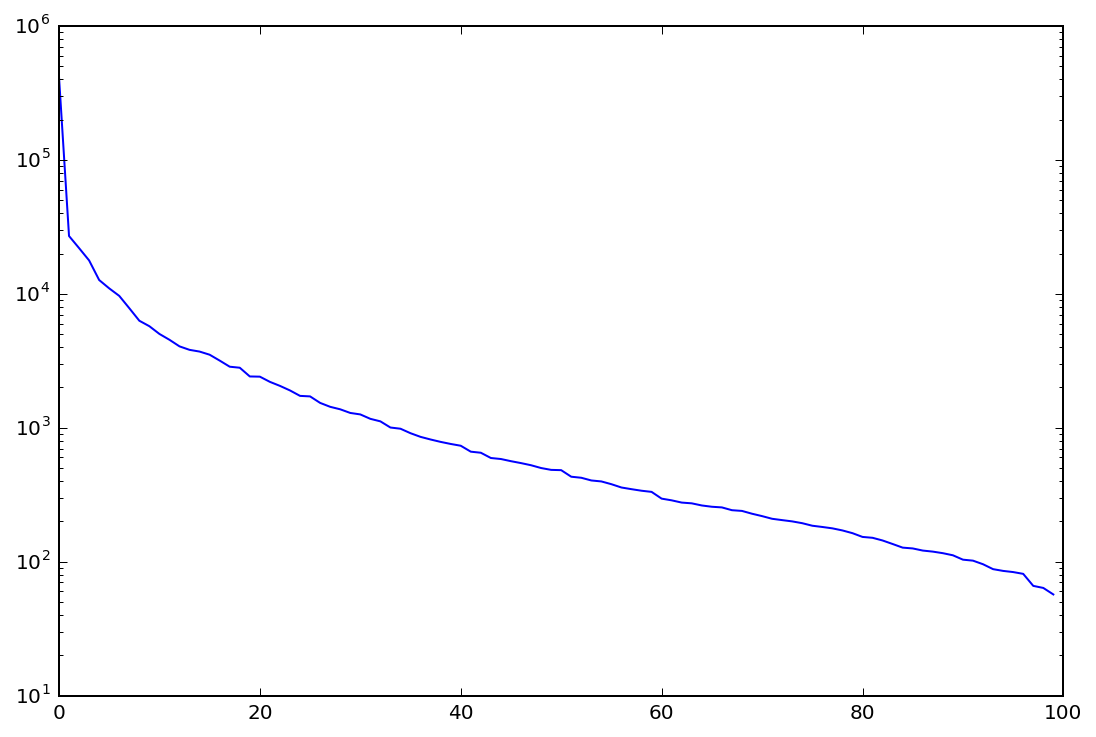

In [36]:
plt.plot(mmd)
ax = plt.axes()
ax.set_yscale('log')

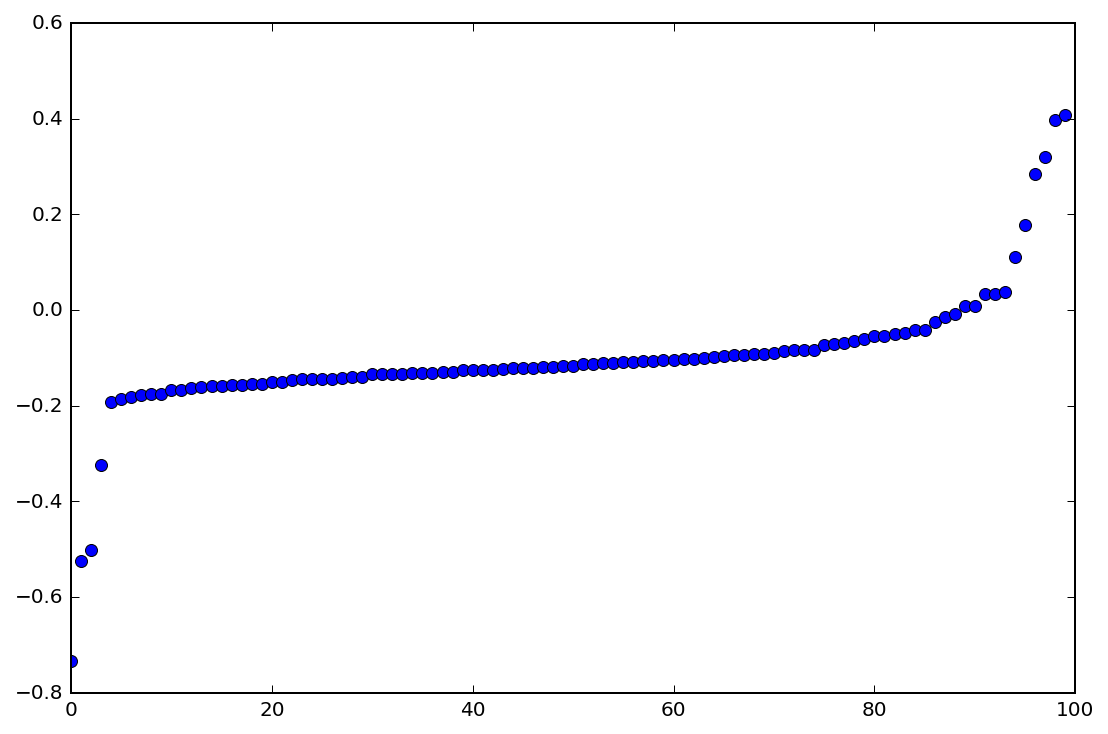

In [37]:
plt.plot(np.sort(mmw[1] + mmw[2] + mmw[0]), 'o')

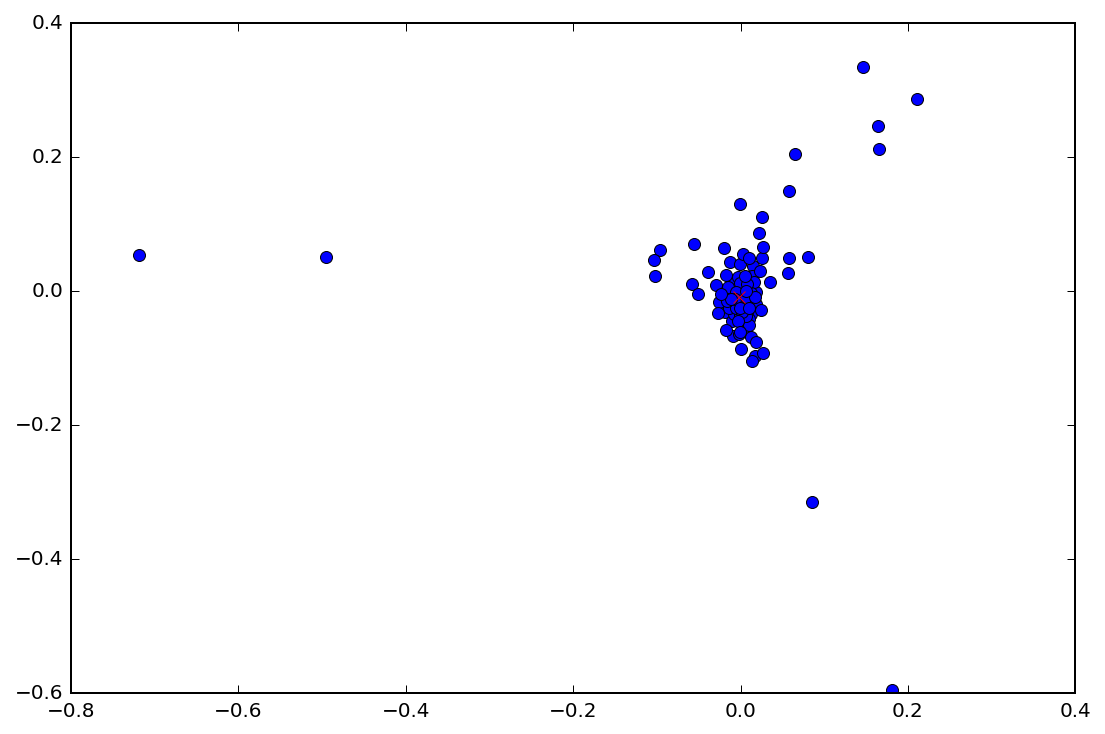

In [38]:
plt.plot(mmw[1], mmw[2], 'o')
plt.plot(mmw[1, center_state], mmw[2, center_state], 'rx')

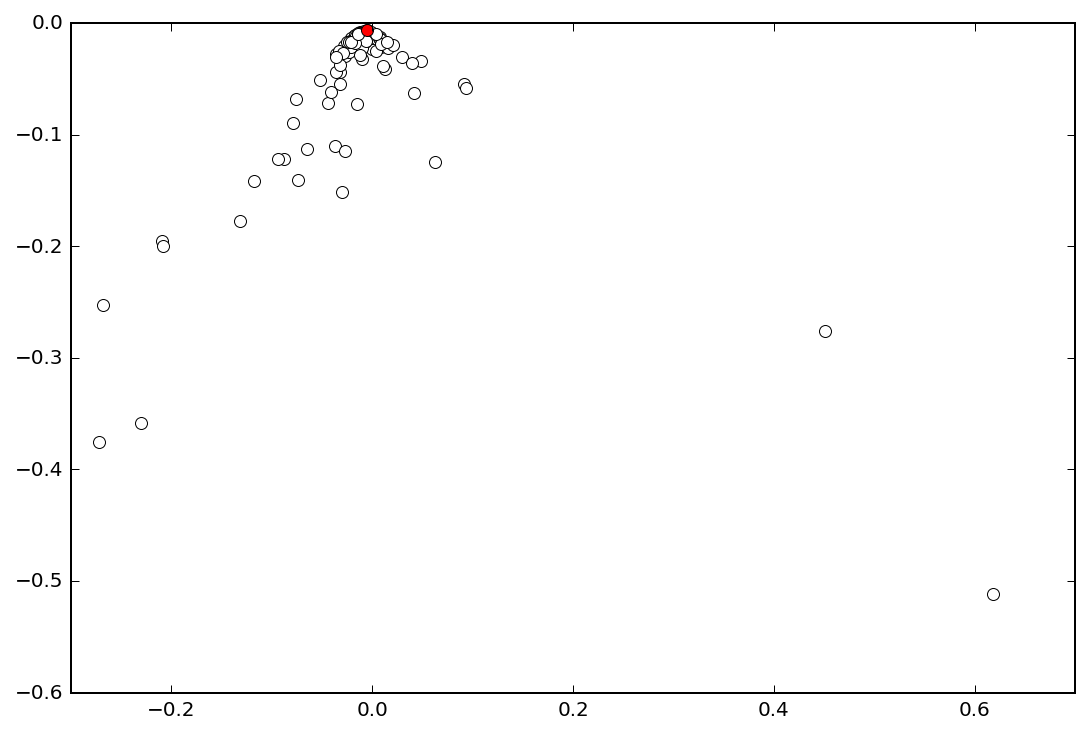

In [39]:
plt.plot(mmv[:,1], mmv[:,0], 'ow')
plt.plot(mmv[center_state, 1], mmv[center_state, 0], 'ro')

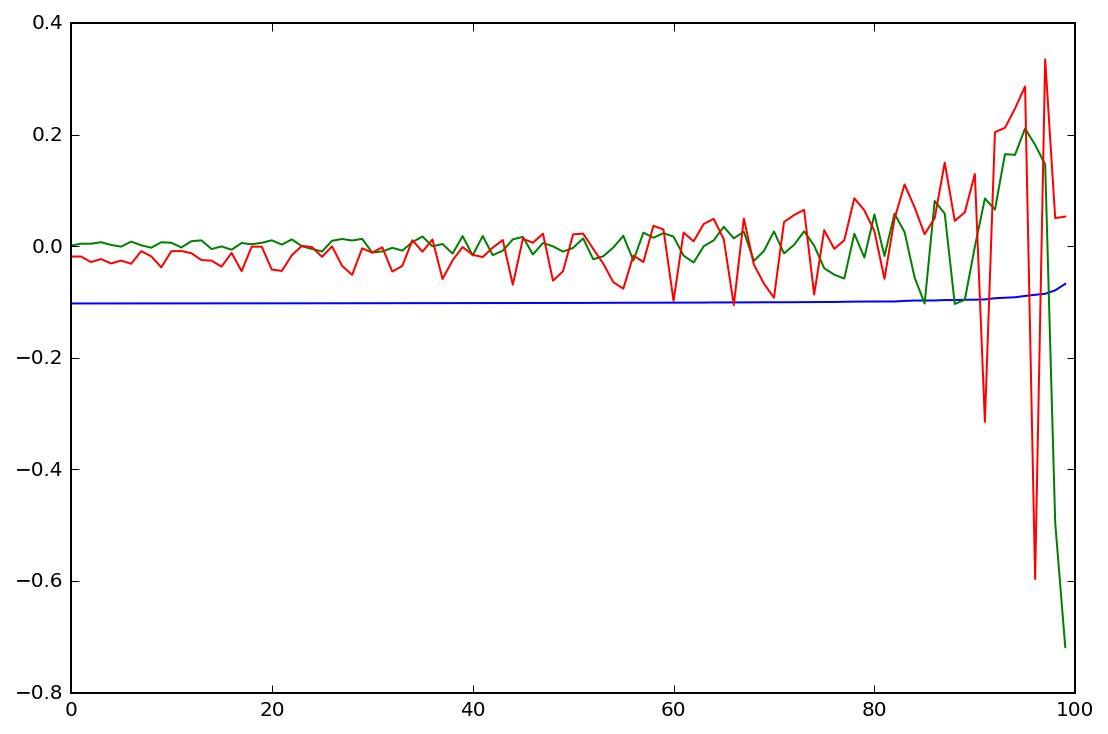

In [40]:
idx = np.argsort(mmw[0])
plt.plot(mmw[0, idx])
plt.plot(mmw[1, idx])
plt.plot(mmw[2, idx])

In [41]:
appr_mfpt = np.dot(np.dot(mmv[:,0:2], np.diag(mmd[0:2])), mmw[0:2])

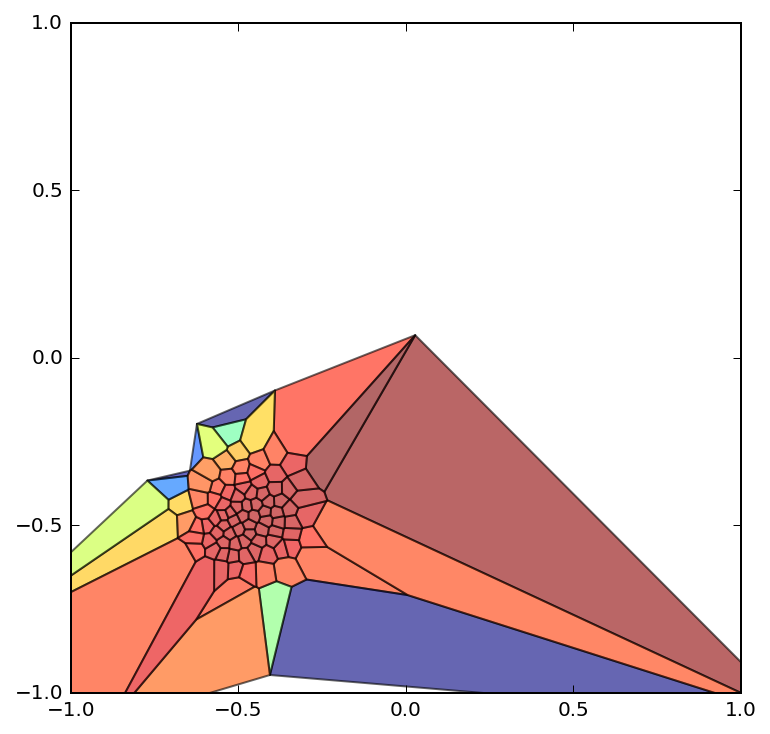

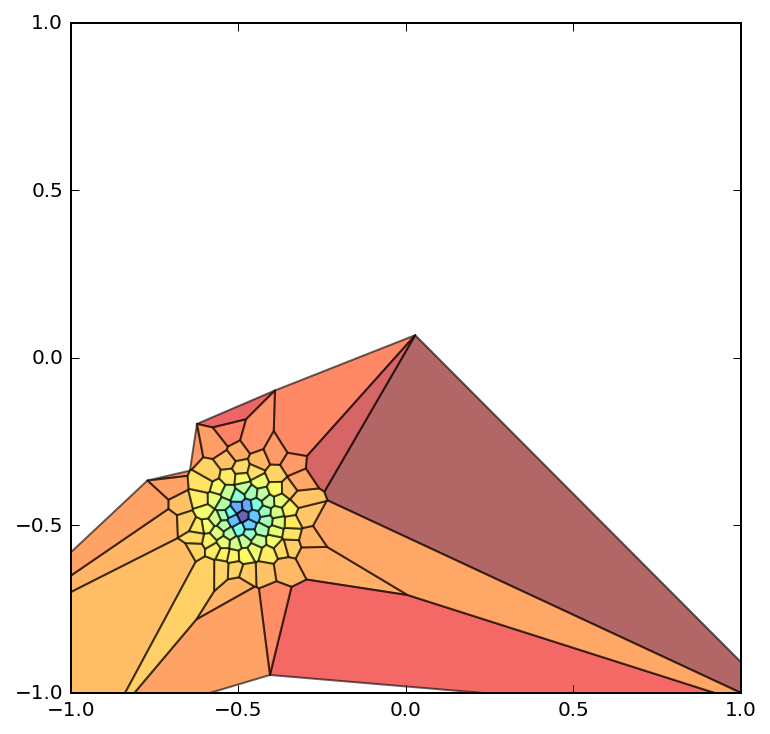

In [43]:
voronoi_plot(ccc, appr_mfpt[center_state])
voronoi_plot(ccc, m1[center_state])

5551.82956137


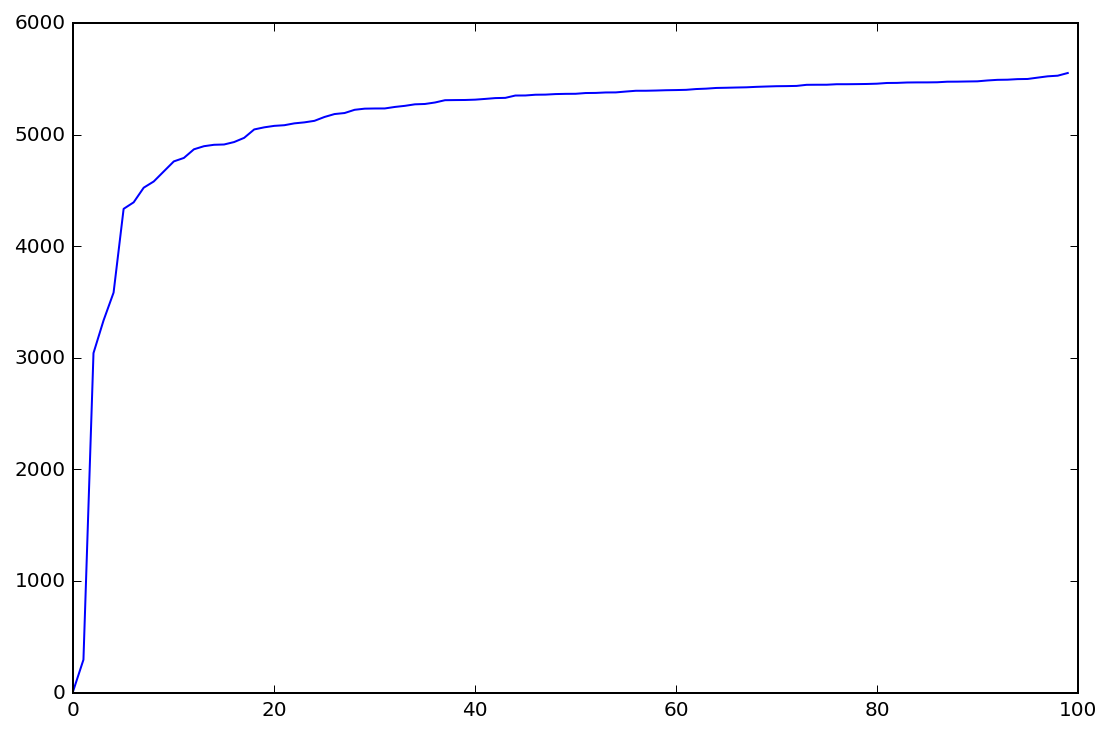

In [44]:
xx = m1[22]
plt.plot(np.sort(xx))
print max(xx)

In [45]:
print np.dot(m1, np.linalg.inv(m1.T))

[[ 0.89074583 -0.14723783 -0.10560611 ...,  0.14196048  0.26666046
   0.00696126]
 [-0.09417828  0.87430954 -0.09038609 ...,  0.11741586  0.22229015
   0.00412065]
 [-0.11216774 -0.15140208  0.89145246 ...,  0.14670399  0.27523548
   0.00751024]
 ..., 
 [-0.26965553 -0.3764931  -0.26754099 ...,  1.40310538  0.73874265
   0.03718416]
 [-1.03526061 -1.47074188 -1.04046558 ...,  1.64956524  3.99201848
   0.18143985]
 [-0.16874633 -0.23226761 -0.16566705 ...,  0.23881799  0.44175369
   1.0181708 ]]


/Users/jan-hendrikprinz/anaconda/lib/python2.7/site-packages/numpy/core/numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


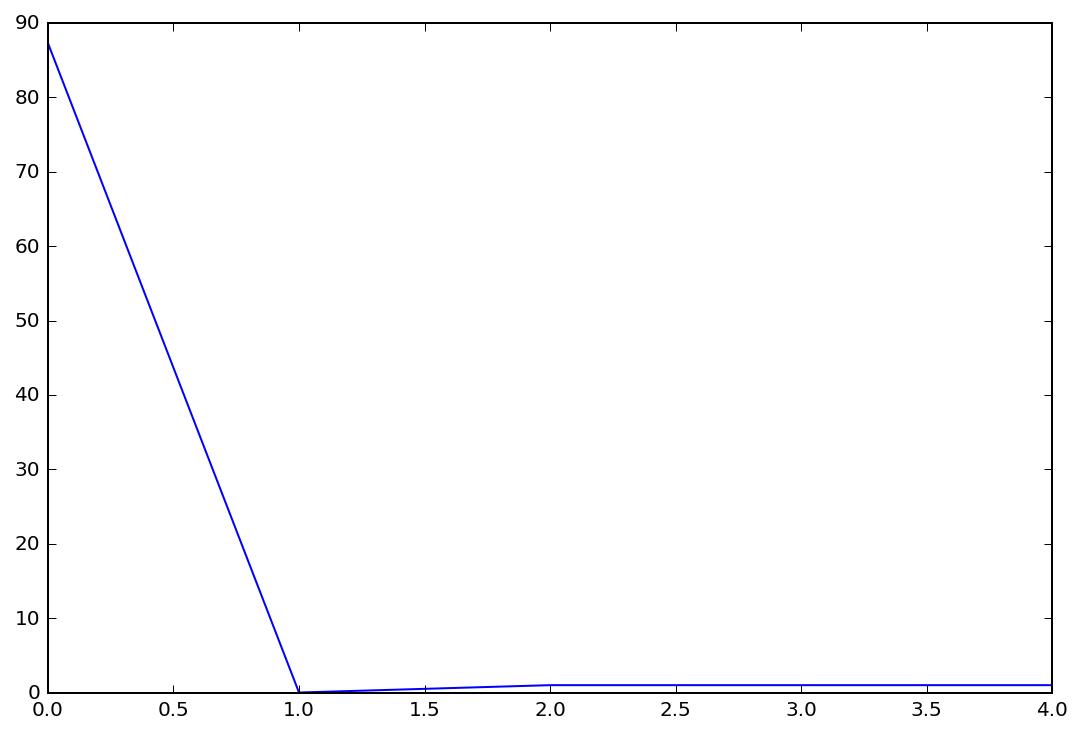

In [46]:
plt.plot(np.linalg.eigvals(np.dot(m1, np.linalg.inv(m1.T)))[0:5])

In [47]:
np.real(np.around(np.linalg.eigvals(np.dot(m1.T, np.linalg.inv(m1)) - im)[0:10], 10))

NameError: name 'im' is not defined

In [48]:
np.dot(np.linalg.inv(m1), m1.T) - np.identity(len(m1))

array([[-0.10925417, -0.09417828, -0.11216774, ..., -0.26965553,
        -1.03526061, -0.16874633],
       [-0.14723783, -0.12569046, -0.15140208, ..., -0.3764931 ,
        -1.47074188, -0.23226761],
       [-0.10560611, -0.09038609, -0.10854754, ..., -0.26754099,
        -1.04046558, -0.16566705],
       ..., 
       [ 0.14196048,  0.11741586,  0.14670399, ...,  0.40310538,
         1.64956524,  0.23881799],
       [ 0.26666046,  0.22229015,  0.27523548, ...,  0.73874265,
         2.99201848,  0.44175369],
       [ 0.00696126,  0.00412065,  0.00751024, ...,  0.03718416,
         0.18143985,  0.0181708 ]])

393.621019289


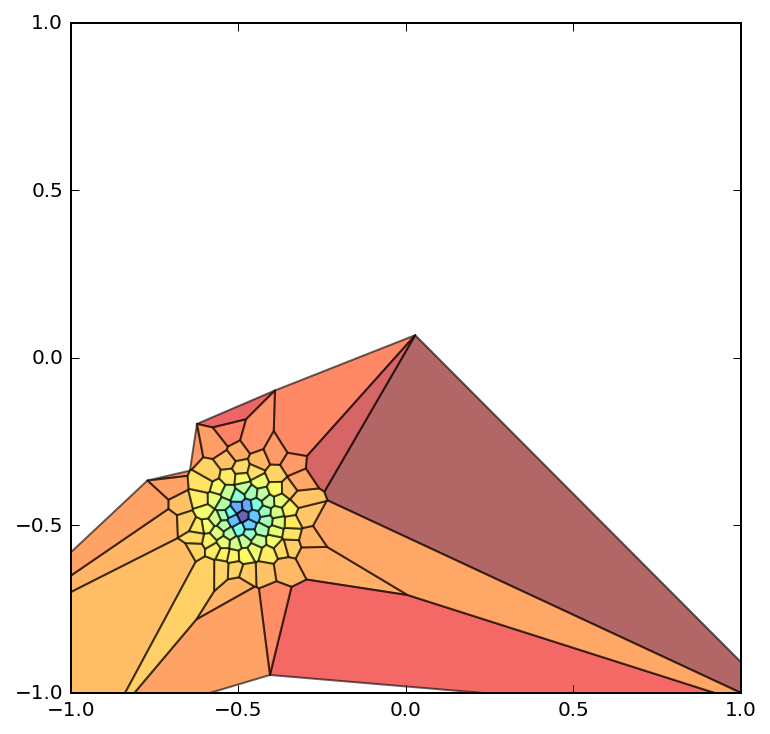

In [49]:
vv = m1[center_state].copy()
print max(vv)
vv[vv > 44800.0] = 0.0
voronoi_plot(ccc, vv)

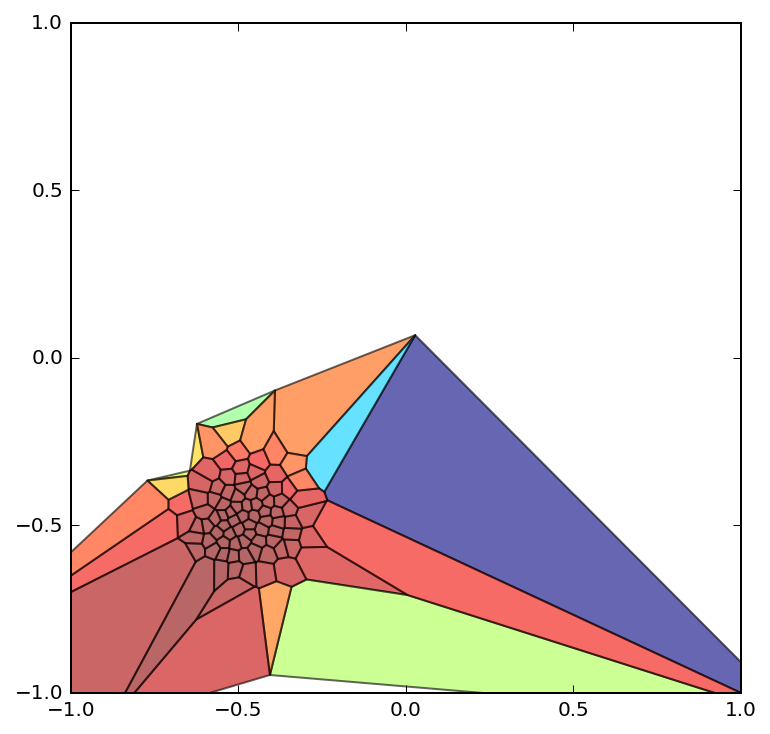

In [50]:
voronoi_plot(ccc, mmw[0])

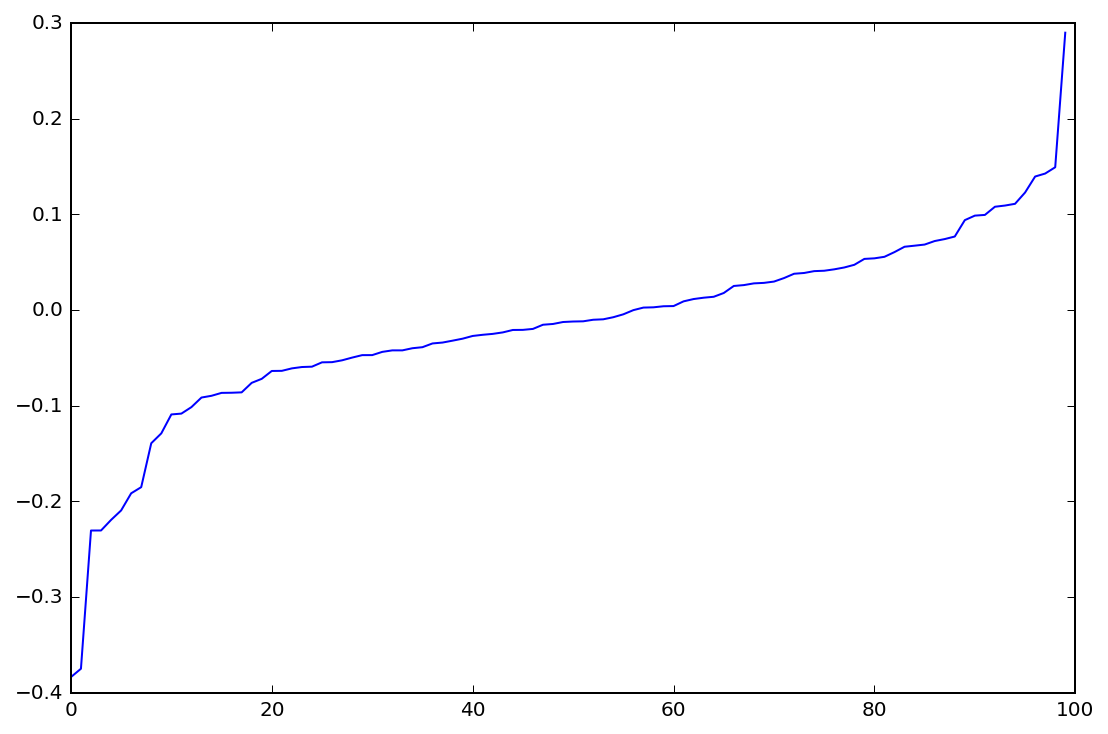

In [51]:
plt.plot(np.sort(np.linalg.eig(m1.T)[1][0]))

In [52]:
pcca_clustering = mymsm.pcca(3)

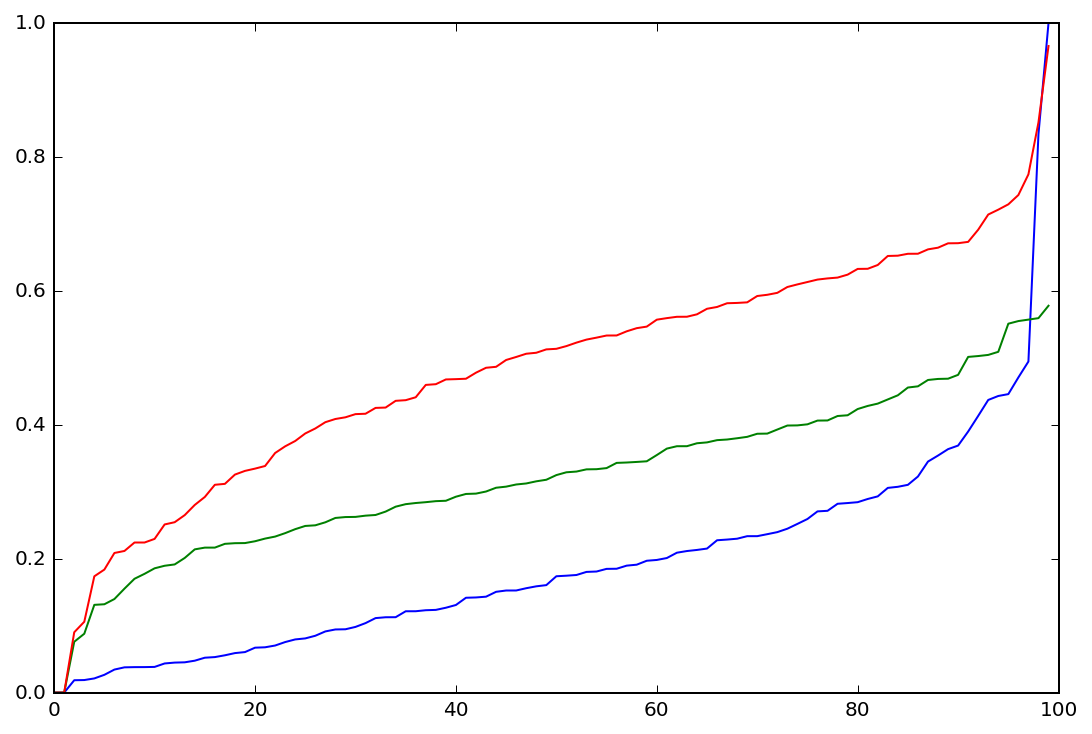

In [53]:
plt.plot(np.sort(pcca_clustering.memberships[:,0]))
plt.plot(np.sort(pcca_clustering.memberships[:,1]))
plt.plot(np.sort(pcca_clustering.memberships[:,2]))

Confine dynamics to one state

### Defining states and interfaces

TIS methods usually require that you define states and interfaces before starting the simulation. State and interfaces are both defined in terms of `Volume` objects. The most common type of `Volume` is one based on some set of collective variables, so the first thing we have to do is to define the collective variable.

For this system, we'll define the collective variables as circles centered on the middle of the state. OPS allows us to define one function for the circle, which is parameterized by different centers. Note that each collective variable is in fact a separate function.

In [54]:
def circle_sq(snapshot, center):
    return (snapshot.xyz[0][0]-center[0])**2 + (snapshot.xyz[0][1]-center[1])**2
    
opA = paths.CV_Function(name="opA", f=circle_sq, center=[-0.5, -0.5], cv_time_reversible=True)
opB = paths.CV_Function(name="opB", f=circle_sq, center=[0.5, -0.5], cv_time_reversible=True)
opC = paths.CV_Function(name="opC", f=circle_sq, center=[0.0, 0.4], cv_time_reversible=True)

Now we define the states and interfaces in terms of these order parameters. The `CVRangeVolumeSet` gives a shortcut to create several volume objects using the same collective variable.

In [8]:
stateA = paths.CVRangeVolume(opA, 0.0, 0.2**2)
stateB = paths.CVRangeVolume(opB, 0.0, 0.2**2)
stateC = paths.CVRangeVolume(opC, 0.0, 0.2**2)

interfacesA = paths.VolumeFactory.CVRangeVolumeSet(opA, 0.0,[0.2**2, 0.3**2, 0.4**2, 0.5**2])
interfacesB = paths.VolumeFactory.CVRangeVolumeSet(opB, 0.0,[0.2**2, 0.3**2, 0.4**2, 0.5**2])
interfacesC = paths.VolumeFactory.CVRangeVolumeSet(opC, 0.0,[0.2**2, 0.3**2, 0.4**2, 0.5**2])

### Build the MSTIS transition network

Once we have the collective variables, states, and interfaces defined, we can create the entire transition network. In this one small piece of code, we create all the path ensembles needed for the simulation, organized into structures to assist with later analysis.

In [9]:
mstis = paths.MSTISNetwork([
    (stateA, interfacesA, opA),
    (stateB, interfacesB, opB),
    (stateC, interfacesC, opC)
])

### Bootstrap to fill all interfaces

Now we actually run the bootstrapping calculation. The `full_bootstrap` function requires an initial snapshot in the state, and then it will generate trajectories satisfying TIS ensemble for the given interfaces. To fill all the ensembles in the MSTIS network, we need to do this once for each initial state.

In [10]:
initA = toys.Snapshot(
    coordinates=np.array([[-0.5, -0.5]]), 
    velocities=np.array([[1.0,0.0]]),
)
bootstrapA = paths.FullBootstrapping(
    transition=mstis.from_state[stateA],
    snapshot=initA,
    engine=toy_eng,
    extra_interfaces=[interfacesA[-1]]
)
gsA = bootstrapA.run()

DONE! Completed Bootstrapping cycle step 46 in ensemble 4/4 .



In [11]:
initB = toys.Snapshot(
    coordinates=np.array([[0.5, -0.5]]), 
    velocities=np.array([[-1.0,0.0]]),
)

bootstrapB = paths.FullBootstrapping(
    transition=mstis.from_state[stateB], 
    snapshot=initB, 
    engine=toy_eng, 
    extra_interfaces=[interfacesB[-1]]
)
gsB = bootstrapB.run()

DONE! Completed Bootstrapping cycle step 18 in ensemble 4/4 .



In [12]:
initC = toys.Snapshot(
    coordinates=np.array([[0.0, 0.4]]), 
    velocities=np.array([[0.0,-0.5]]),
)
bootstrapC = paths.FullBootstrapping(
    transition=mstis.from_state[stateC], 
    snapshot=initC, 
    engine=toy_eng, 
    extra_interfaces=[interfacesC[-1]]
)
gsC = bootstrapC.run()

DONE! Completed Bootstrapping cycle step 30 in ensemble 4/4 .



Now that we've done that for all 3 states, let's look at the trajectories we generated.

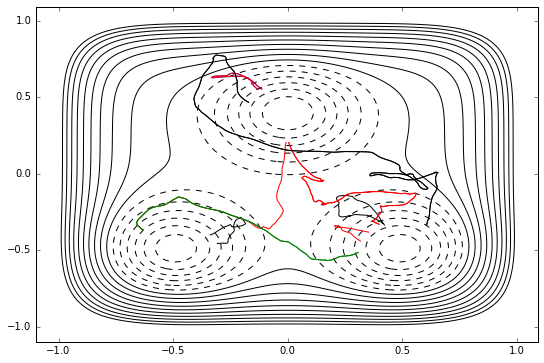

In [13]:
plot.plot([s.trajectory for s in gsA]+[s.trajectory for s in gsB]+[s.trajectory for s in gsC]);

Finally, we join these into one `SampleSet`. The function `relabel_replicas_per_ensemble` ensures that the trajectory associated with each ensemble has a unique replica ID.

In [14]:
total_sample_set = paths.SampleSet.relabel_replicas_per_ensemble(
    [gsA, gsB, gsC]
)

### Storing stuff

Up to this point, we haven't stored anything in files. In other notebooks, a lot of the storage is done automatically. Here we'll show you how to store a few things manually. Instead of storing the entire bootstrapping history, we'll only store the final trajectories we get out.

First we create a file. When we create it, the file also requires the `template` snapshot.

In [15]:
storage = paths.Storage("mstis_bootstrap.nc", "w", template=template)

The storage will recursively store data, so storing `total_sample_set` leads to automatic storage of all the `Sample` objects in that sample set, which in turn leads to storage of all the ensemble, trajectories, and snapshots.

Since the path movers used in bootstrapping and the engine are not required for the sample set, they would not be stored. We explicitly store the engine for later use, but we won't need the path movers, so we don't try to store them.

The `sync_all()` function ensures that all the data that has been created is also saved to the file.

In [16]:
storage.save(total_sample_set)
storage.save(toy_eng)
storage.sync_all()

Now we check to make sure that we actually have stored the objects that we claimed to store. There should be 0 pathmovers, 1 engine, 12 samples (4 samples from each of 3 transitions), and 1 sample set. There will be some larger number of snapshots. There will also be a larger number of ensembles, because each ensemble is defined in terms of subensembles, each of which gets saved.

In [17]:
print "PathMovers:", len(storage.pathmovers)
print "Engines:", len(storage.engines)
print "Samples:", len(storage.samples)
print "SampleSets:", len(storage.samplesets)
print "Snapshots:", len(storage.snapshots)
print "Ensembles:", len(storage.ensembles)

PathMovers: 0
Engines: 1
Samples: 12
SampleSets: 1
Snapshots: 1966
Ensembles: 120


Finally, we close the storage. Not strictly necessary, but a good habit.

In [18]:
storage.close()